# Artificial Intelligence  

## Project 3:  House Price Estimation using Both Visual and Textual Data

### Developed By:

    Vrushank Shah
   

### Problem Formulation:

The goal of this project is to build a novel house price estimation system by using both textual and visual inputs, rather than only using textual information such as area, neighborhood, and number of bedrooms. Build the best deep learning model and show its RMSE and lift chart on test data.  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import of required libraries
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets,linear_model, preprocessing,utils
from sklearn.metrics import mean_squared_error,r2_score
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure, show
from keras.layers import Conv1D, Conv2D, MaxPooling2D 
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten ,Dropout
import cv2
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
import glob
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from IPython.display import Image
from sklearn import preprocessing

In [0]:
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [0]:
#Read the data i.e. text file and give column headers
cols=["Bedrooms","Bathrooms","Area","Zipcode","Price"]
data_text = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Houses Dataset/HousesInfo.txt' , sep=" ", header=None , names=cols)

In [0]:
data_text 

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [0]:
data_text.shape

(535, 5)

In [0]:
#Check for null values
data_text.isnull().sum()

Bedrooms     0
Bathrooms    0
Area         0
Zipcode      0
Price        0
dtype: int64

In [0]:
#Read the bathroom images from the given path
new_images=[]
for number in range(1, 536):
    for path in glob.glob("/content/drive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [0]:
new_images

['/content/drive/My Drive/Colab Notebooks/Houses Dataset/1_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/2_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/3_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/4_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/5_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/6_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/7_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/8_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/9_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/10_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/11_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/12_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses Dataset/13_bathroom.jpg',
 '/content/drive/My Drive/Colab No

In [0]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [0]:
#Read the bedroom images from the given path
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("/content/drive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path)
img['bedroom_img']=bedroom_images 

In [0]:
#Read the frontal images from the given path
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("/content/drive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 
img['frontal_img']=frontal_images

In [0]:
#Read the kitchen images from the given path
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("/content/drive/My Drive/Colab Notebooks/Houses Dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 
img['kitchen_img']=kitchen_images

In [0]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
1,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
2,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
3,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
4,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...


In [0]:
img.shape

(535, 4)

In [0]:
#Combine the images and text file into a single dataframe to remove outliers
combined_result = pd.concat([data_text, img], axis=1, sort=False)

In [0]:
combined_result

,Bedrooms,Bathrooms,Area,Zipcode,Price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,869500,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
1,4,3.0,3343,36372,865200,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
2,3,4.0,3923,85266,889000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
3,5,5.0,4022,85262,910000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
4,3,4.0,4116,85266,971226,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
...,...,...,...,...,...,...,...,...,...
530,5,2.0,2066,94531,399900,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
531,4,3.5,9536,94531,460000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
532,3,2.0,2014,94531,407000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
533,4,3.0,2312,94531,419000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...


In [0]:
#Remove outliers i.e. keep the houses with a price between 100K and 900K 
result = combined_result[combined_result['Price'] >=100000] 
result = result[result['Price'] <=900000] 

result

,Bedrooms,Bathrooms,Area,Zipcode,Price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,869500,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
1,4,3.0,3343,36372,865200,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
2,3,4.0,3923,85266,889000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
6,3,4.0,2544,85262,799000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
10,5,5.0,4829,85266,519200,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
...,...,...,...,...,...,...,...,...,...
530,5,2.0,2066,94531,399900,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
531,4,3.5,9536,94531,460000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
532,3,2.0,2014,94531,407000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
533,4,3.0,2312,94531,419000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...


In [0]:
img = result.drop(['Bedrooms','Bathrooms','Area','Zipcode','Price'], axis = 1, inplace = False) 

In [0]:
img

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
1,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
2,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
6,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
10,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
...,...,...,...,...
530,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
531,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
532,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
533,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...


In [0]:
result

,Bedrooms,Bathrooms,Area,Zipcode,Price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,869500,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
1,4,3.0,3343,36372,865200,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
2,3,4.0,3923,85266,889000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
6,3,4.0,2544,85262,799000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
10,5,5.0,4829,85266,519200,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
...,...,...,...,...,...,...,...,...,...
530,5,2.0,2066,94531,399900,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
531,4,3.5,9536,94531,460000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
532,3,2.0,2014,94531,407000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
533,4,3.0,2312,94531,419000,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...


In [0]:
txt = result.drop(['bathroom_img','bedroom_img','frontal_img','kitchen_img'], axis = 1, inplace = False) 

In [0]:
txt

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [0]:
#Image Processing
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
            
        
            images_output.append(outputImage)      
            

In [ ]:
from matplotlib import pyplot as plt

for i in images_output:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     plt.show()

In [0]:
img_arr=np.asarray(images_output)

In [0]:
img_arr.shape

(406, 128, 128, 3)

In [0]:
txt

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [ ]:
img_arr

In [0]:
txt

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [0]:
#One hot encoding of categorical features
encode_text_dummy(txt,'Bedrooms')
encode_text_dummy(txt,'Bathrooms')
encode_text_dummy(txt,'Zipcode')

In [0]:
txt.shape

(406, 62)

In [0]:
#Normalizing the numerical feature using z-score normalization
encode_numeric_zscore(txt,'Area')

In [0]:
txt

,Area,Price,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-7,Bedrooms-8,Bedrooms-10,Bathrooms-1.0,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0,Zipcode-36372,Zipcode-60002,Zipcode-60016,Zipcode-60046,Zipcode-62025,Zipcode-62034,Zipcode-62088,Zipcode-62214,Zipcode-62234,Zipcode-62249,Zipcode-81418,Zipcode-81521,Zipcode-81524,Zipcode-85255,Zipcode-85262,Zipcode-85266,Zipcode-85331,Zipcode-91752,Zipcode-91901,Zipcode-91915,Zipcode-92021,Zipcode-92253,Zipcode-92276,Zipcode-92543,Zipcode-92677,Zipcode-92692,Zipcode-92802,Zipcode-92880,Zipcode-93105,Zipcode-93111,Zipcode-93314,Zipcode-93446,Zipcode-93510,Zipcode-94501,Zipcode-94531,Zipcode-94565,Zipcode-94568,Zipcode-95220,Zipcode-96019,Zipcode-98021
0,1.541416,869500,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.918549,865200,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.427370,889000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.217604,799000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2.222184,519200,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.201735,399900,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
531,6.351532,460000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
532,-0.247354,407000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
533,0.014075,419000,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
#Create a copy and drop 'Price' to separate target feature from other feautures
txt_copy = txt.copy()
txt_copy.drop('Price',axis=1,inplace=True)

In [0]:
#Create variables for the train_test_split function
x_text = txt_copy
y_text = txt['Price']

In [0]:
x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(x_text, y_text, test_size=0.3, random_state=42)
print("Shape of x_train_text: {}".format(x_train_text.shape))
print("Shape of x_test_text: {}".format(x_test_text.shape))
print("Shape of y_train_text: {}".format(y_train_text.shape))
print("Shape of y_test_text: {}".format(y_test_text.shape))

Shape of x_train_text: (284, 61)
Shape of x_test_text: (122, 61)
Shape of y_train_text: (284,)
Shape of y_test_text: (122,)


In [0]:
train_img, test_img = train_test_split(img_arr, test_size=0.3, random_state=42)
print("Shape of train_img: {}".format(train_img.shape))
print("Shape of test_img: {}".format(test_img.shape))

Shape of train_img: (284, 128, 128, 3)
Shape of test_img: (122, 128, 128, 3)


In [0]:
x_train_text

,Area,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-7,Bedrooms-8,Bedrooms-10,Bathrooms-1.0,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0,Zipcode-36372,Zipcode-60002,Zipcode-60016,Zipcode-60046,Zipcode-62025,Zipcode-62034,Zipcode-62088,Zipcode-62214,Zipcode-62234,Zipcode-62249,Zipcode-81418,Zipcode-81521,Zipcode-81524,Zipcode-85255,Zipcode-85262,Zipcode-85266,Zipcode-85331,Zipcode-91752,Zipcode-91901,Zipcode-91915,Zipcode-92021,Zipcode-92253,Zipcode-92276,Zipcode-92543,Zipcode-92677,Zipcode-92692,Zipcode-92802,Zipcode-92880,Zipcode-93105,Zipcode-93111,Zipcode-93314,Zipcode-93446,Zipcode-93510,Zipcode-94501,Zipcode-94531,Zipcode-94565,Zipcode-94568,Zipcode-95220,Zipcode-96019,Zipcode-98021
428,0.903635,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
225,-0.720206,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
154,-1.021113,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
40,6.392764,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
316,0.602729,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-0.884257,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147,-0.149976,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
363,-0.919349,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
473,-0.512292,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
y_train_text

428    549000
225    769000
154    170000
40     395000
316    479000
        ...  
100    549000
147    728000
363    114500
473    310000
141    895000
Name: Price, Length: 284, dtype: int64

In [0]:
x_test_text

,Area,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-7,Bedrooms-8,Bedrooms-10,Bathrooms-1.0,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0,Zipcode-36372,Zipcode-60002,Zipcode-60016,Zipcode-60046,Zipcode-62025,Zipcode-62034,Zipcode-62088,Zipcode-62214,Zipcode-62234,Zipcode-62249,Zipcode-81418,Zipcode-81521,Zipcode-81524,Zipcode-85255,Zipcode-85262,Zipcode-85266,Zipcode-85331,Zipcode-91752,Zipcode-91901,Zipcode-91915,Zipcode-92021,Zipcode-92253,Zipcode-92276,Zipcode-92543,Zipcode-92677,Zipcode-92692,Zipcode-92802,Zipcode-92880,Zipcode-93105,Zipcode-93111,Zipcode-93314,Zipcode-93446,Zipcode-93510,Zipcode-94501,Zipcode-94531,Zipcode-94565,Zipcode-94568,Zipcode-95220,Zipcode-96019,Zipcode-98021
99,0.991363,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
297,1.290515,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
338,-1.172005,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56,-0.106989,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65,1.291392,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.951886,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
84,0.383409,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,1.237001,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
402,-0.429827,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
y_test_text

99     679000
297    567000
338    135000
56     439900
65     254900
        ...  
426    725000
84     689000
108    848000
402    179000
306    560000
Name: Price, Length: 122, dtype: int64

In [0]:
train_img.shape

(284, 128, 128, 3)

In [0]:
test_img.shape

(122, 128, 128, 3)

## Keras Functional API 





Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 61)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          15872       dense_1_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 125, 125, 32) 1568        input_1[0][0]                    
________________________________________________________________________________________

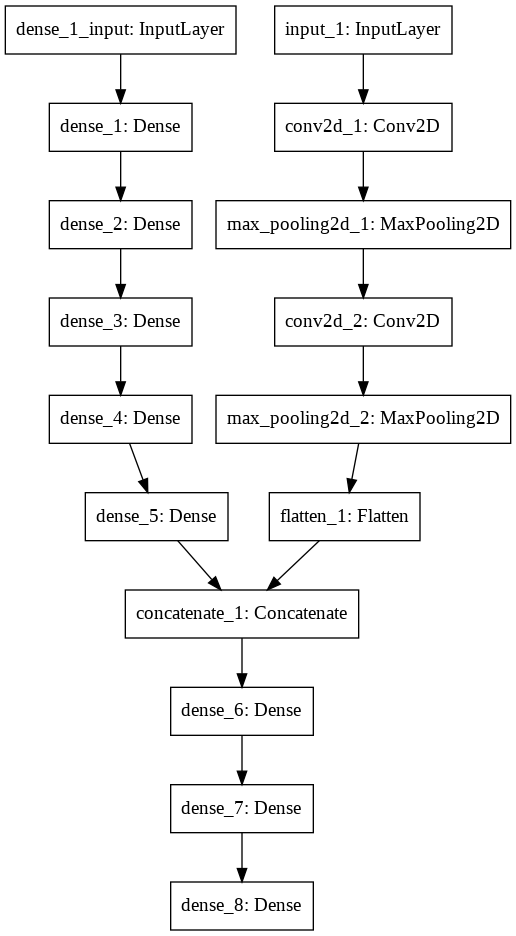

In [0]:
# first input model to process text
model1 = Sequential()
model1.add(Dense(256, input_dim=x_train_text.shape[1], activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(32, activation="relu"))
model1.add(Dense(1, activation="relu"))


# second input model to process images
visible2 = Input(shape=(128,128,3))
conv21 = Conv2D(32, kernel_size=4, activation='relu')(visible2)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(16, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
flat2 = Flatten()(pool22)
model2 = Model(visible2, flat2)

# merge input models
merge = concatenate([model1.output, model2.output])

# interpretation model
hidden1 = Dense(50, activation='relu')(merge)
hidden2 = Dense(40, activation='relu')(hidden1)
output = Dense(1, activation='relu')(hidden2)

model = Model(inputs=[model1.input, model2.input], outputs=output)
# summarize layers
print(model.summary())

# plot model
plot_model(model)

In [0]:
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model 

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit([x_train_text, train_img], y_train_text,batch_size=64,validation_data=([x_test_text, test_img], y_test_text),callbacks=[monitor],verbose=2,epochs=1000)





Train on 284 samples, validate on 122 samples
Epoch 1/1000





 - 15s - loss: 281422818808.7887 - val_loss: 283269737488.7869
Epoch 2/1000
 - 0s - loss: 279922393318.7606 - val_loss: 275845703377.8361
Epoch 3/1000
 - 0s - loss: 264386151092.2817 - val_loss: 234149544204.5901
Epoch 4/1000
 - 0s - loss: 200525930611.3803 - val_loss: 118451054424.1311
Epoch 5/1000
 - 0s - loss: 75255859632.6761 - val_loss: 73379675421.3770
Epoch 6/1000
 - 0s - loss: 83862467309.9718 - val_loss: 57208282330.2295
Epoch 7/1000
 - 0s - loss: 51296805960.1127 - val_loss: 56247644697.1803
Epoch 8/1000
 - 0s - loss: 61564292831.5493 - val_loss: 55904071612.8525
Epoch 9/1000
 - 0s - loss: 50303232201.9155 - val_loss: 46535669592.1311
Epoch 10/1000
 - 0s - loss: 52101793878.5352 - val_loss: 55287644025.7049
Epoch 11/1000
 - 0s - loss: 49406830851.6056 - val_loss: 45688015620.1967
Epoch 12/1000
 - 0s - loss: 48167102781.2958 - val_loss: 47802050727.8689
Epoch 13/1000
 - 0s - loss: 47993662103.4366 - val_loss: 

In [0]:
from sklearn import metrics

model_pred = model.predict([x_test_text,test_img])

score = np.sqrt(metrics.mean_squared_error(y_test_text,model_pred)) 

print("Score (RMSE) : {}".format(score))

Score (RMSE) : 120017.71388399428


In [0]:
model_pred = np.asarray(model_pred)
y_test_text = np.asarray(y_test_text)

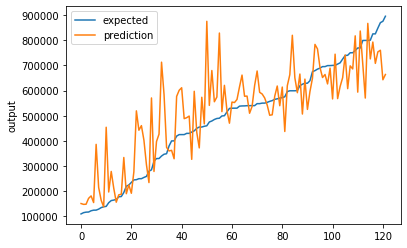

In [0]:
chart_regression(model_pred.flatten(),y_test_text)